In [31]:
import codecs
import pandas as pd

from konlpy.tag import Okt as Twitter
from sklearn.feature_extraction.text import CountVectorizer

import torch
import torch.nn as nn
import torch.utils.data as Data

import numpy as np
import random

from sklearn.model_selection import train_test_split

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

# Prepare Data

In [6]:
f = codecs.open('data/reviews.txt', 'r', 'utf-8')
f.read()[:500]

'# G마켓에 좋은 평만 있어서 사봤는데.. 정말 진짜 진짜 사지마세요. 개. 쓰. 레. 기 (진심) 입니다. 액정부터 짜증나는 TN패널에, 하드 SSD인걸로 알았는데, 속도는 저질 SD카드 꽂아 놓은것 같습니다. 정말 느려터집니다. 저는 단지 인터넷 뱅킹만 할려고, 샀단 말입니다. 그런데 인터넷 뱅킹 프로그램까는데만 10~20분 걸립니다. 뭐약!! 이게!! 분노로 인해 볼때마다 짜증납니다. 밤에 잠도 안오고요.. 사시면 분명 후회하실겁니다. 아! 진짜 G마켓 프리미엄평으로 실날하게 사진찍어서 올리려고했는데, 먹고 산다고 바빠서 프리미엄 평 못 올린게 정말 천추의 한이네요!!\n# 원래 그런 줄 알고 사는 "저가 제품"이라고 생각합니다만. IPS라는 언급이 없으니 당연히 TN 패널일 테고, EMMC는 SSD가 아니고 SD 카드 내장된 것 같은 것이라 원래 SSD보다 느린 것이고, CPU도 아톰이니 뭐 당연히 느리죠. 그런 것 다 감안하고 "싸고 가볍다"는 조건으로 사는 제품인데요. 뭐 '

# Extract Sentences

In [7]:
keywords = ["발열", "소음"]

for keyword in keywords:
    temp_list = []
    save_name = "data/reviews_" + keyword + ".txt"
    f = codecs.open("data/reviews.txt", "r", "utf-8")
    t = codecs.open(save_name, "w", "utf-8")
    
    while True:
        line = f.readline()
        if not line: break
        if keyword in line:
            temp_list.append(line)
    set_list = list(set(temp_list))
    
    for item in set_list:
        t.write(item)

    f.close()
    t.close()

In [9]:
f = codecs.open('data/reviews_발열.txt', 'r', 'utf-8')
f.read()[:500]

'# 노트북 진짜로 디자인 깔끔하고 이뻐요! 오피스깔고 기타프로그램 설치하는것도 빨라요! 써봐야 알겠지만 발열도 거의 없고 쿨링팬 소음도 거의 없어요! 노트북 어느정도 크긴 큰데 상당히 가벼워요 대박! 가성비 짱짱 인거 같아연>\n# 맨처음 상자 열어서 꺼내 들었을 때 깜짝놀랐어요 너무 가벼워요.얘가 넘 연약한거 아닌가 장난감인가 싶을 정도로 정말 가벼워서 놀랬어요 왠만한 책보다 가벼워요.렘 업그레이드 추가해서 구매했는데 잘 되어서 왔구요 .엄청 빠르고 좋아요. 소음도 한개도 없어요. 정말 조용해요 발열은 캠 있는부분 조금 따뜻한 느낌으로 있구요. 크게 신경쓰일 정도는 아니에요 노트북 가볍고 좋습니다.\n# 맥북, 그램, 노트북9 중 뭐살지 일주일을 고민하다 결국 노트북9으로 결정했습니다.램도 듀얼채널이고 발열이나 터치패드 감도나 키감 등이 다 최상위권 인것 같습니다. 무게에 너무 집중하여 많은 기본기를 잃은 그램보다는 노트북9이 한수 위라고 생각되네요.맥북하고 고민은 많이 했습니다. 디'

# Load Scored Data

In [10]:
filename = 'data/score_발열.xlsx'
sheet_name = 'Sheet1'
data = pd.read_excel(filename, sheet_name=sheet_name, header=0)

csv_data = [item.replace('#', '').strip() for item in data['Review']]
csv_label = data['Score']

In [14]:
csv_data[:5], csv_label[:5]

(['발열히 심한거 같은데 여름이라 그런가?..',
  '발열이좀 심한거 같아서 걱정이에요',
  '발열이심하더라구요',
  '발열이너무심한게 제일큰 단점인것 같고 그외에 불편한점은',
  '발열이...정말...심합니다'],
 0    2
 1    2
 2    2
 3    2
 4    2
 Name: Score, dtype: int64)

In [15]:
scores = [sum(csv_label == 0), sum(csv_label == 1), sum(csv_label == 2)]
scores

[703, 370, 138]

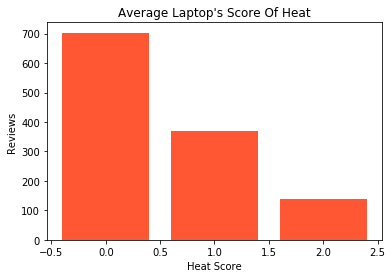

In [18]:
plt.bar(range(len(scores)), scores, color = "#ff5733")
plt.title("Average Laptop's Score Of Heat")
plt.xlabel("Heat Score")
plt.ylabel("Reviews")
plt.show()

# Bag Of Words

In [34]:
twitter = Twitter()
doc = []

for sentence in csv_data:
    results = []
    tokens = twitter.pos(sentence, norm=True, stem=True)
    for token in tokens:
        if not token[1] in ["Josa", "Eomi", "Punctuation"]:
            results.append(token[0])
    doc.append(" ".join(results).strip())

In [35]:
doc[:5]

['발열 히 심하다 같다 여름 그 런가',
 '발열 이 좀 심하다 같다 걱정',
 '발열 심하다',
 '발열 이 너 무심하다 제일 크다 단점 것 같다 그 외 불편하다 점',
 '발열 정말 심하다']

In [38]:
cnv = CountVectorizer(ngram_range=(1, 1), min_df = 3)

data = cnv.fit_transform(doc).toarray()
print(data[0])
label = csv_label.values
print(label)

[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[2 2 2 ... 0 0 0]


In [39]:
cnv.vocabulary_

{'발열': 112,
 '심하다': 156,
 '같다': 13,
 '여름': 187,
 '걱정': 16,
 '무심하다': 104,
 '크다': 266,
 '단점': 57,
 '불편하다': 125,
 '정말': 237,
 '확실하다': 292,
 '심해': 157,
 '노트북': 45,
 '쿨러': 263,
 '사용': 134,
 '크게': 265,
 '진짜': 250,
 '너무': 43,
 '많이': 93,
 '있다': 218,
 '장시간': 228,
 '높다': 47,
 '프로그램': 275,
 '한편': 283,
 '이다': 204,
 '심다': 155,
 '밧데리': 113,
 'cpu': 4,
 '용량': 200,
 '빼다': 131,
 '괜찮다': 22,
 '느낌': 50,
 '하지만': 281,
 '자판': 221,
 '조금': 241,
 '속도': 149,
 '매우': 94,
 '좋다': 244,
 '이전': 211,
 '하다': 279,
 '뜨겁다': 83,
 '가볍다': 10,
 '조용하다': 242,
 '마음': 88,
 '듭니': 72,
 '돌아가다': 65,
 '불량': 124,
 '심해지다': 158,
 '생기다': 141,
 '소리': 147,
 '나다': 38,
 '그렇다': 31,
 '부분': 122,
 '문제': 107,
 '끊기다': 37,
 '쓰다': 160,
 '약간': 175,
 '게임': 18,
 '돌리다': 64,
 '정도': 236,
 '성능': 145,
 '라면': 85,
 '지다': 249,
 '이렇다': 206,
 '부팅': 123,
 '화상': 289,
 '원래': 202,
 '모르다': 100,
 '않다': 171,
 '구매': 24,
 '신분': 154,
 '야하다': 174,
 '제외': 239,
 '자주': 220,
 '발생': 111,
 '삼성': 137,
 '소음': 148,
 '치다': 259,
 '만족하다': 91,
 '배터리': 116,
 '빠르다': 128,
 '무엇': 105,
 '생각': 

# Train-Test Split

In [40]:
dim = len(cnv.vocabulary_)

In [41]:
train_data, test_data, train_label, test_label = train_test_split(data, label, stratify = label)

print(len(train_data))
print(len(test_data))

908
303


In [45]:
x = torch.from_numpy(train_data).type(torch.FloatTensor)
y = torch.from_numpy(train_label).type(torch.LongTensor)

In [46]:
y.size(), x.size()

(torch.Size([908]), torch.Size([908, 295]))

In [47]:
train_data = Data.TensorDataset(x, y)
batch_size = 10
train_loader = Data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers=1, drop_last=True)

# Define and Train Model

In [48]:
linear1 = nn.Linear(dim, 200, bias=True)
linear2 = nn.Linear(200, 3, bias=True)

relu = nn.ReLU()

model = nn.Sequential(linear1, relu, linear2)

In [49]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [50]:
num_epochs = 50

In [51]:
for epoch in range(num_epochs):
    total_batch = len(train_data) // batch_size
    for i, (batch_text, batch_labels) in enumerate(train_loader):
        X = batch_text.view(-1, dim)
        Y = batch_labels
        
        pre = model(X)
        cost = loss(pre, Y)
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        if (i + 1) % 20 == 0:
            print('Epoch [%d/%d], lter [%d/%d] Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, cost.item()))
    
print("Learning Finished!")

Epoch [1/50], lter [20/90] Loss: 0.9397
Epoch [1/50], lter [40/90] Loss: 1.0582
Epoch [1/50], lter [60/90] Loss: 0.6918
Epoch [1/50], lter [80/90] Loss: 0.9955
Epoch [2/50], lter [20/90] Loss: 0.5593
Epoch [2/50], lter [40/90] Loss: 0.7867
Epoch [2/50], lter [60/90] Loss: 0.7392
Epoch [2/50], lter [80/90] Loss: 0.5639
Epoch [3/50], lter [20/90] Loss: 0.5588
Epoch [3/50], lter [40/90] Loss: 0.2007
Epoch [3/50], lter [60/90] Loss: 0.5443
Epoch [3/50], lter [80/90] Loss: 0.7605
Epoch [4/50], lter [20/90] Loss: 0.3347
Epoch [4/50], lter [40/90] Loss: 0.2876
Epoch [4/50], lter [60/90] Loss: 0.3186
Epoch [4/50], lter [80/90] Loss: 0.1204
Epoch [5/50], lter [20/90] Loss: 0.2242
Epoch [5/50], lter [40/90] Loss: 0.2342
Epoch [5/50], lter [60/90] Loss: 0.2593
Epoch [5/50], lter [80/90] Loss: 0.2537
Epoch [6/50], lter [20/90] Loss: 0.1300
Epoch [6/50], lter [40/90] Loss: 0.0357
Epoch [6/50], lter [60/90] Loss: 0.0259
Epoch [6/50], lter [80/90] Loss: 0.1675
Epoch [7/50], lter [20/90] Loss: 0.2138


# Test Model

In [53]:
x_test = torch.from_numpy(test_data).type(torch.FloatTensor)
y_test = torch.from_numpy(test_label).type(torch.LongTensor)
test_data = Data.TensorDataset(x_test, y_test)

test_loader = Data.DataLoader(dataset=test_data, batch_size = 1, shuffle=True)

In [54]:
model.eval()

correct = 0
total = 0

for text, labels in test_loader:
    text = text.view(-1, dim)
    outputs = model(text)
    
    _, predicted = torch.max(outputs.data, 1)
    total += 1
    
    correct += (predicted == labels).sum()
    
print("Accuracy of test text: %f %%" % (100 * float(correct) / total))

Accuracy of test text: 82.508251 %


# Test Sentence

In [66]:
def IsitHot(string):
    results = []
    tokens = twitter.pos(string, norm=True, stem=True)
    
    for token in tokens:
        if not token[1] in ["Josa", "Eomi", "Punctuation"]:
            results.append(token[0])
            
    sample = cnv.transform([" ".join(results).strip()]).toarray()
    sample = torch.from_numpy(sample).type(torch.FloatTensor)
    outputs = model(sample)
    pre = torch.max(outputs.data, 1)[1].numpy()
    
    if pre == 0:
        print("분석 결과: 발열 거의 없음")
    elif pre == 1:
        print("분석 결과: 발열 조금 있음")
    else:
        print("분석 결과: 발열 매우 심함")

In [68]:
IsitHot("노트북이 금방 뜨거워지더라고요")

분석 결과: 발열 매우 심함


In [69]:
IsitHot("발열이 없는거 같이 느껴지네요")

분석 결과: 발열 거의 없음
